ML2 VAE by anku rani

In [ ]:
#importing library
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# loading and pre processing data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

def preprocess_data(x_train, x_test):
    
    x_train_p = x_train / 255.0
    x_test_p = x_test / 255.0
    
    sxtrain = np.shape(x_train_p)
    sxtest = np.shape(x_test_p)
    x_train_p = np.reshape(x_train_p, newshape=(sxtrain[0], np.prod(sxtrain[1:])))
    x_test_p = np.reshape(x_test_p, newshape=(sxtest[0], np.prod(sxtest[1:])))
                          
    return x_train_p, x_test_p

training_dataset, validation_dataset = preprocess_data(x_train, x_test)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
training_dataset.shape

(60000, 784)

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [12]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 83s 175ms/step - loss: -485.4991 - val_loss: -508.2115
Epoch 2/50
469/469 [==============================] - 82s 174ms/step - loss: -501.5213 - val_loss: -509.4238
Epoch 3/50
469/469 [==============================] - 81s 172ms/step - loss: -502.4361 - val_loss: -509.7351
Epoch 4/50
469/469 [==============================] - 81s 172ms/step - loss: -501.2098 - val_loss: -509.9986
Epoch 5/50
469/469 [==============================] - 81s 173ms/step - loss: -501.8235 - val_loss: -510.0751
Epoch 6/50
469/469 [==============================] - 81s 172ms/step - loss: -502.8711 - val_loss: -510.1869
Epoch 7/50
469/469 [==============================] - 81s 172ms/step - loss: -502.5890 - val_loss: -510.1613
Epoch 8/50
469/469 [==============================] - 80s 171ms/step - loss: -502.8887 - val_loss: -510.3733
Epoch 9/50
469/469 [==============================] - 80s 171ms/step - loss: -504.3929 - val_loss: -510.4276
Epoch 10/50
469/469

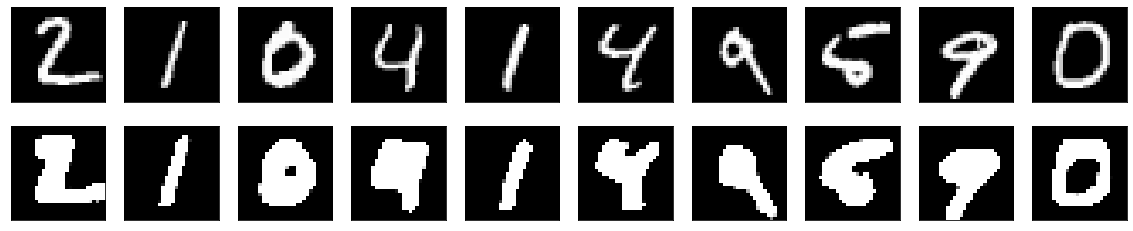

In [13]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [15]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [16]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [17]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [19]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 6s 3ms/step - loss: 223.9903 - val_loss: 169.4485
Epoch 2/100
1875/1875 [==============================] - 6s 3ms/step - loss: 167.4009 - val_loss: 163.6601
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 162.7877 - val_loss: 160.9542
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 159.7030 - val_loss: 158.7322
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 157.8499 - val_loss: 156.8740
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 155.7263 - val_loss: 155.2533
Epoch 7/100
1875/1875 [==============================] - 6s 3ms/step - loss: 154.8077 - val_loss: 154.1909
Epoch 8/100
1875/1875 [==============================] - 6s 3ms/step - loss: 153.3873 - val_loss: 153.1963
Epoch 9/100
1875/1875 [==============================] - 6s 3ms/step - loss: 153.0422 - val_loss: 152.7332
Epoch 10/100
1875/1875 [=============

#visualizing latent space

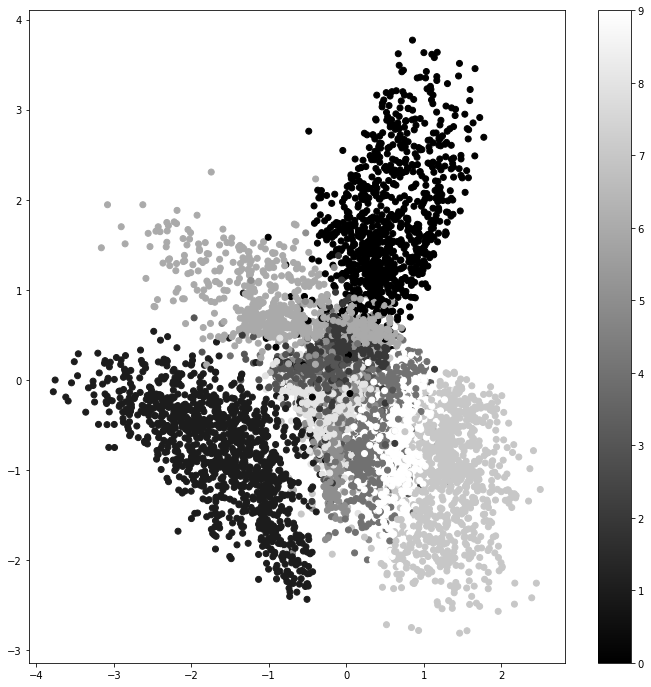

In [57]:
x_test_encoded, _, _ = encoder.predict(x_test)
plt.figure(figsize=(12,12))
plt.scatter(x_test_encoded[:,0],x_test_encoded[:,1], c=y_test)
plt.colorbar()
plt.show()

##a) Plot the Gaussian distributions that you have obtained at the latent space


plot for number 5

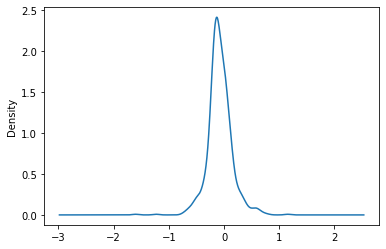

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
x_test_encoded, test_std, _ = encoder.predict(x_test)
frame = pd.DataFrame({'Val_1_mean':x_test_encoded[:, 0], 'Val_2_mean':x_test_encoded[:, 1], 'std_1':test_std[:, 0], 'std_2':test_std[:, 1], "class":y_test})
number_5 = frame.loc[frame['class'] == 5]
number_5['Val_1_mean'].plot.kde()
plt.show()

plot for number 2

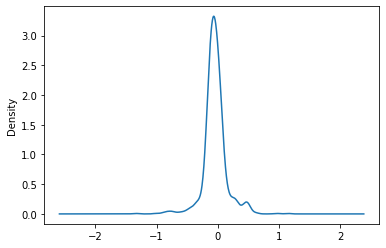

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
x_test_encoded, test_std, _ = encoder.predict(x_test)
frame = pd.DataFrame({'Val_1_mean':x_test_encoded[:, 0], 'Val_2_mean':x_test_encoded[:, 1], 'std_1':test_std[:, 0], 'std_2':test_std[:, 1], "class":y_test})
number_2 = frame.loc[frame['class'] == 2]
number_2['Val_1_mean'].plot.kde()
plt.show()

#few more visualization

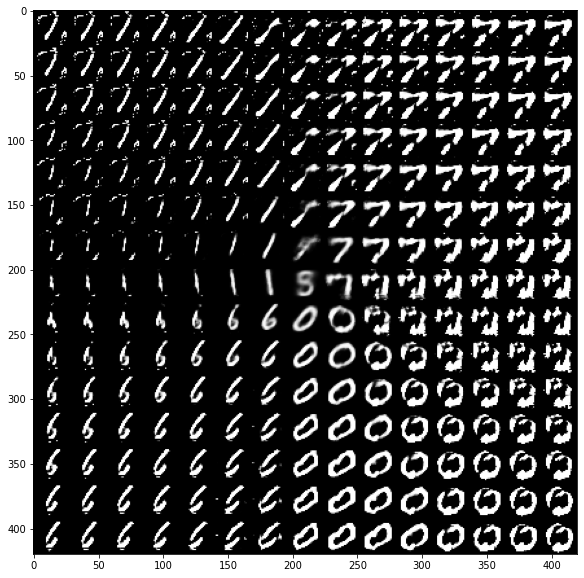

In [24]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

(b) Identify what each latent variable is controlling

0.5409884973251673


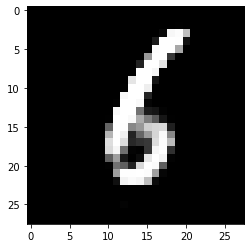

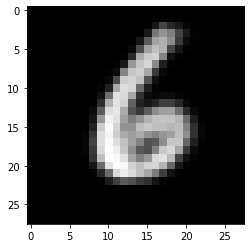

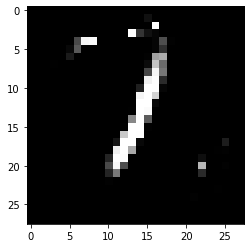

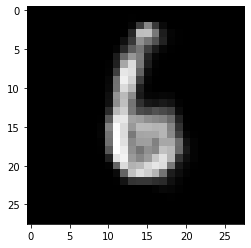

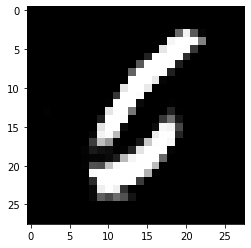

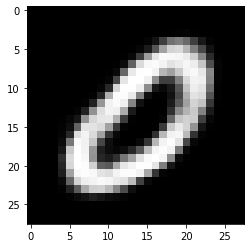

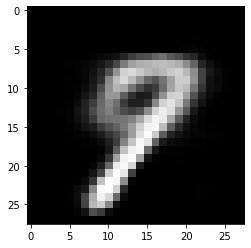

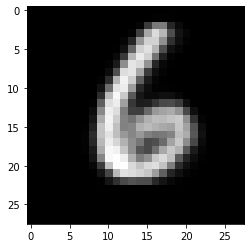

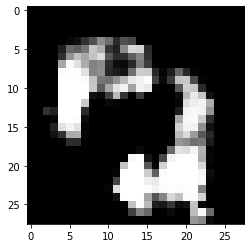

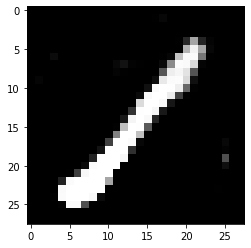

In [55]:
from random import random
import numpy as np
print(random())
count = 10
for i in range(10):
  num1 = np.random.randint(-10, 10)
  x = random() * num1

  num2 = np.random.randint(-10, 10)
  y = random() * num2
  z_sample = np.array([[x, y]])
  x_decoded = decoder.predict(z_sample)
  digit = x_decoded[0].reshape(digit_size, digit_size)
  plt.imshow(digit)      
  plt.show()

Explanation: decoder is predicting the number which is passed from random input and can be visualised on running the code

reference: Keras Blog